## markdown bby
based on google [collab notebook](https://colab.research.google.com/github/google/brax/blob/main/notebooks/environments.ipynb#scrollTo=sz5c_Vg2g0r7)

$$\alpha + \beta = \gamma$$

In [95]:
import functools
import time

from IPython.display import HTML, Image 
import gym

from brax import envs
from brax import jumpy as jp
from brax.envs import to_torch
from brax.io import html
from brax.io import image
import jax
from jax import numpy as jnp
# ==

import torch
v = torch.ones(1)  # init torch cuda before jax

#@title Visualizing pre-included Brax environments { run: "auto" }
#@markdown Select an environment to preview it below:

In [ ]:
environment = "ant"  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'reacher', 'walker2d', 'fetch', 'grasp', 'ur5e']
env = envs.create(env_name=environment)
state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

# Stepping and Jitting Environments

We operate environments via `env.step`:

$$
\text{state}_{t+1} = \text{env.step}(\text{state}_t, \text{action})
$$


The state returned by `env.step` contains:
* the physics state `QP`
* the observation vector
* reward
* whether the environment is done and needs to be reset
* other useful metrics.

By calling `env.step` in sequence we produce a rollout:

In [107]:
%%time
rollout = []
for i in range(100):
  # wiggle sinusoidally with a phase shift per actuator
  action = jp.sin(i * jp.pi / 15 + jp.arange(0, env.action_size) * jp.pi)
  state = env.step(state, action)
  rollout.append(state)

CPU times: user 50.8 s, sys: 99.2 ms, total: 50.9 s
Wall time: 50.8 s


In [98]:
state = jax.jit(env.step)(state, jnp.ones((env.action_size,)))

In [108]:
HTML(html.render(env.sys, [s.qp for s in rollout]))

# OpenAI Gym Wrapper + PyTorch

Brax environments can converted to Gym environments, using either [GymWrapper](https://github.com/google/brax/blob/main/brax/envs/wrappers.py) for single environments, or [VectorGymWrapper](https://github.com/google/brax/blob/main/brax/envs/wrappers.py) for batched (parallelized) environments.  Gym-wrapped Brax environments are jit-compiled, and can interoperate with (and share accelerator resources with) other learning frameworks such as PyTorch.

In [100]:
entry_point = functools.partial(envs.create_gym_env, env_name='ant')
if 'brax-ant-v0' not in gym.envs.registry.env_specs:
  gym.register('brax-ant-v0', entry_point=entry_point)

# create a gym environment that contains 4096 parallel ant environments
gym_env = gym.make("brax-ant-v0", batch_size=4096)

# wrap it to interoperate with torch data structures
gym_env = to_torch.JaxToTorchWrapper(gym_env)

# jit compile env.reset
obs = gym_env.reset()

# jit compile env.step
action = torch.rand(gym_env.action_space.shape) * 2 - 1
obs, reward, done, info = gym_env.step(action)

In [101]:
obs.shape

torch.Size([4096, 87])

In [102]:
before = time.time()
rollout = []
state_ = env.reset(rng=jp.random_prngkey(seed=0))
for _ in range(100):
  action = torch.rand([1,8])
  # action = torch.rand(gym_env.action_space.shape) * 2 - 1
  action = jp.random_uniform(1, env.action_size)
  # state_ = gym_env.step(action)
  state_ = env.step(state_, action)
  # obs, rewards, done, info = state_
  rollout.append(state_)

duration = time.time() - before
print(f'time for {409600} steps: {duration:.2f}s ({int(409600 / duration)} steps/sec)')

time for 409600 steps: 19.41s (21106 steps/sec)


In [103]:
action = jp.sin(i * jp.pi / 15 + jp.arange(0, env.action_size) * jp.pi)
action.shape
# action_th = torch.rand(gym_env.action_space.shape) * 2 - 1
action_th = torch.rand((0,8))
action_th = jp.random_uniform(2,8)
action_th

array([0.26161213, 0.29849114, 0.81422574, 0.09191594, 0.60010053,
       0.72856053, 0.18790107, 0.05514663])

In [105]:
HTML(html.render(env.sys, [s.qp for s in rollout]))


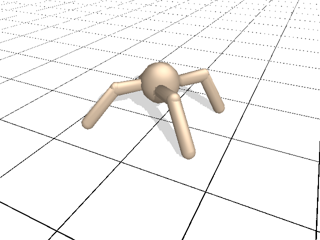

In [106]:
Image(image.render(env.sys, [s.qp for s in rollout], width=320, height=240))